# Deep Time Series Classification

The time series classification problem seems to be a great choice to apply Deep Learning models. However, even deep models cannot magically give you good results if the data wasn't propertly prepared. 

The [CareerCon 2019 competition](https://www.kaggle.com/c/career-con-2019) was all about time series classification. In [one of my previous kernels](https://www.kaggle.com/purplejester/a-simple-lstm-based-time-series-classifier), I've tried to apply LSTM model to the dataset and didn't get too impressive accuracy. Also, I was experimenting with 1-d convolutions but again without any luck. So finally, I decided to go with [a more simple apporach](https://www.kaggle.com/purplejester/the-best-friend-of-an-alchemist). Nevertheless, when the competition was ended, [one of the best solutions](https://www.kaggle.com/prith189/starter-code-for-3rd-place-solution) implemented by [prith189](https://www.kaggle.com/prith189) uses Deep Learning to achieve a decent result on both public and private leaderboard.

In this notebook, we're going to use PyTorch to create a clone of the mentioned solution and see if we can improve it a bit using modern training techniques.

<img src="https://i.imgur.com/XWrG9ys.png" width="500"></img>

## Imports

In addition to PyTorch, we use "standard" Python's data science stack. Also, there are couple of additional functions from the standard library used in utils and snippets.

In [1]:
from collections import defaultdict
from functools import partial
from multiprocessing import cpu_count
from pathlib import Path
from textwrap import dedent

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.externals import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
from torch.optim.lr_scheduler import _LRScheduler
from torch.utils.data import TensorDataset, DataLoader

In [3]:
seed = 1
np.random.seed(seed)

In [4]:
# path to sample submission
sample = Path.cwd().parent/'input'/'career-con-2019'/'sample_submission.csv'

## Reading The Preprocessed Dataset

As it was already mentioned above, we use a preprocessed data from [this kernel](https://www.kaggle.com/prith189/starter-code-for-3rd-place-solution) to train our models. The preprocessed data was added as a custom dataset. The major differences from the "raw" data:
1. the `orientaion_[XYZW]` columns were converted into Euler angles (original columns were dropped);
2. each measurment sequence was shifted to have zero mean;
3. the whole dataset was normalized into `[-1, +1]` range;
4. the linear and angular accelerations and velocities were processed with `np.fft.rfft` call and saved as an _additional_ dataset to extend the original data.

In [5]:
ROOT = Path.cwd().parent/'input'/'career-con-2019-preprocessed-data'
enc = joblib.load(ROOT/'encoder.model')
raw_arr = np.load(ROOT/'feat.npy').transpose(0, 2, 1)
fft_arr = np.load(ROOT/'feat_fft.npy').transpose(0, 2, 1)
target = np.load(ROOT/'target.npy')
print(dedent(f'''
Dataset shapes:
    raw: {raw_arr.shape}
    fft: {fft_arr.shape}
    target: {target.shape}
'''))


Dataset shapes:
    raw: (7626, 9, 128)
    fft: (7626, 6, 65)
    target: (7626,)



Please note that the testing and training data are concatenated into a single Numpy array. The first `3810` rows are the training samples. The rest of rows represent the testing data with dummy labels.

## PyTorch Datasets and Data Loaders

We create three datasets and data loaders for them to make the data ready for model's training. The process is straightforward. We split the labelled data into two subsets, and keep testing data as is. Also, we convert Numpy arrays into `torch.tensor` objects of proper type (float for samples, and long - for targets).

In [6]:
def create_datasets(data, target, train_size, valid_pct=0.1, seed=None):
    """Converts NumPy arrays into PyTorch datsets.
    
    Three datasets are created in total:
        * training dataset
        * validation dataset
        * testing (un-labelled) dataset

    """
    raw, fft = data
    assert len(raw) == len(fft)
    sz = train_size
    idx = np.arange(sz)
    trn_idx, val_idx = train_test_split(
        idx, test_size=valid_pct, random_state=seed)
    trn_ds = TensorDataset(
        torch.tensor(raw[:sz][trn_idx]).float(), 
        torch.tensor(fft[:sz][trn_idx]).float(), 
        torch.tensor(target[:sz][trn_idx]).long())
    val_ds = TensorDataset(
        torch.tensor(raw[:sz][val_idx]).float(), 
        torch.tensor(fft[:sz][val_idx]).float(), 
        torch.tensor(target[:sz][val_idx]).long())
    tst_ds = TensorDataset(
        torch.tensor(raw[sz:]).float(), 
        torch.tensor(fft[sz:]).float(), 
        torch.tensor(target[sz:]).long())
    return trn_ds, val_ds, tst_ds

In [7]:
def create_loaders(data, bs=128, jobs=0):
    """Wraps the datasets returned by create_datasets function with data loaders."""
    
    trn_ds, val_ds, tst_ds = data
    trn_dl = DataLoader(trn_ds, batch_size=bs, shuffle=True, num_workers=jobs)
    val_dl = DataLoader(val_ds, batch_size=bs, shuffle=False, num_workers=jobs)
    tst_dl = DataLoader(tst_ds, batch_size=bs, shuffle=False, num_workers=jobs)
    return trn_dl, val_dl, tst_dl

Next, we're going to create a couple of helper classes to build a classifier. The `torch` framework doesn't have a dedicated `SeparableConv` layers. But we easily can replicate them with the following class. (Which was taken from one of the PyTorch forum's threads). As the code below shows, the separable convolution is a pretty simple thing: two convolutions following one another. The major purpose of this type of layer is to [reduce the number of model's parameters](https://arxiv.org/pdf/1704.04861.pdf).

In [8]:
class _SepConv1d(nn.Module):
    """A simple separable convolution implementation.
    
    The separable convlution is a method to reduce number of the parameters 
    in the deep learning network for slight decrease in predictions quality.
    """
    def __init__(self, ni, no, kernel, stride, pad):
        super().__init__()
        self.depthwise = nn.Conv1d(ni, ni, kernel, stride, padding=pad, groups=ni)
        self.pointwise = nn.Conv1d(ni, no, kernel_size=1)

    def forward(self, x):
        return self.pointwise(self.depthwise(x))

Also, we extend a bit the separable convolution layer with activation layer and dropout to simplify the layers initialization process and reduce the number of code lines in the model.

In [9]:
class SepConv1d(nn.Module):
    """Implementes a 1-d convolution with 'batteries included'.
    
    The module adds (optionally) activation function and dropout layers right after
    a separable convolution layer.
    """
    def __init__(self, ni, no, kernel, stride, pad, drop=None,
                 activ=lambda: nn.ReLU(inplace=True)):
    
        super().__init__()
        assert drop is None or (0.0 < drop < 1.0)
        layers = [_SepConv1d(ni, no, kernel, stride, pad)]
        if activ:
            layers.append(activ())
        if drop is not None:
            layers.append(nn.Dropout(drop))
        self.layers = nn.Sequential(*layers)
        
    def forward(self, x): 
        return self.layers(x)

The `Flatten` layer replicates `Reshape` layer from `Keras` and makes the convolution layer output ready to pass them into `nn.Linear` layers.

In [10]:
class Flatten(nn.Module):
    """Converts N-dimensional tensor into 'flat' one."""

    def __init__(self, keep_batch_dim=True):
        super().__init__()
        self.keep_batch_dim = keep_batch_dim

    def forward(self, x):
        if self.keep_batch_dim:
            return x.view(x.size(0), -1)
        return x.view(-1)

Finally, we create our classifier using the layers created above. As you see, the model consists of two separate "paths" which output is concatenated and then passed into the top layers. One path uses the "raw" data, and the second one - the data processed with FFT. Therefore, we don't drop the original data but use it in addition to the processed observations.

In [11]:
class Classifier(nn.Module):
    def __init__(self, raw_ni, fft_ni, no, drop=.5):
        super().__init__()
        
        self.raw = nn.Sequential(
            SepConv1d(raw_ni,  32, 8, 2, 3, drop=drop),
            SepConv1d(    32,  64, 8, 4, 2, drop=drop),
            SepConv1d(    64, 128, 8, 4, 2, drop=drop),
            SepConv1d(   128, 256, 8, 4, 2),
            Flatten(),
            nn.Dropout(drop), nn.Linear(256, 64), nn.ReLU(inplace=True),
            nn.Dropout(drop), nn.Linear( 64, 64), nn.ReLU(inplace=True))
        
        self.fft = nn.Sequential(
            SepConv1d(fft_ni,  32, 8, 2, 4, drop=drop),
            SepConv1d(    32,  64, 8, 2, 4, drop=drop),
            SepConv1d(    64, 128, 8, 4, 4, drop=drop),
            SepConv1d(   128, 128, 8, 4, 4, drop=drop),
            SepConv1d(   128, 256, 8, 2, 3),
            Flatten(),
            nn.Dropout(drop), nn.Linear(256, 64), nn.ReLU(inplace=True),
            nn.Dropout(drop), nn.Linear( 64, 64), nn.ReLU(inplace=True))
        
        self.out = nn.Sequential(
            nn.Linear(128, 64), nn.ReLU(inplace=True), nn.Linear(64, no))
        
    def forward(self, t_raw, t_fft):
        raw_out = self.raw(t_raw)
        fft_out = self.fft(t_fft)
        t_in = torch.cat([raw_out, fft_out], dim=1)
        out = self.out(t_in)
        return out

In [12]:
trn_sz = 3810  # only the first `trn_sz` rows in each array include labelled data

In [13]:
datasets = create_datasets((raw_arr, fft_arr), target, trn_sz, seed=seed)

In [14]:
# make sure that we run on a proper device (not relevant for Kaggle kernels but helpful in Jupyter sessions)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

Now everything is ready to create a training loop and see if our model works. For each training epoch, the loop performs the following actions:
1. train model on the `trn_ds` dataset;
2. verify quality on the `val_ds` dataset;
3. check if the quality improved since previous epoch, and if so, save the model's weights onto disk;
4. in case if the model's quality isn't impoving for `patience` epochs, the training is stopped.

Also, the code tracks loss and accuracy history, and prints current scores with exponentially increasing logging frequency, i.e., only at 1, 2, 4, 8... epochs.

In [15]:
raw_feat = raw_arr.shape[1]
fft_feat = fft_arr.shape[1]

trn_dl, val_dl, tst_dl = create_loaders(datasets, bs=256)

lr = 0.001
n_epochs = 3000
iterations_per_epoch = len(trn_dl)
num_classes = 9
best_acc = 0
patience, trials = 500, 0
base = 1
step = 2
loss_history = []
acc_history = []

model = Classifier(raw_feat, fft_feat, num_classes).to(device)
criterion = nn.CrossEntropyLoss(reduction='sum')
opt = optim.Adam(model.parameters(), lr=lr)

print('Start model training')

for epoch in range(1, n_epochs + 1):
    
    model.train()
    epoch_loss = 0
    for i, batch in enumerate(trn_dl):
        x_raw, x_fft, y_batch = [t.to(device) for t in batch]
        opt.zero_grad()
        out = model(x_raw, x_fft)
        loss = criterion(out, y_batch)
        epoch_loss += loss.item()
        loss.backward()
        opt.step()
        
    epoch_loss /= trn_sz
    loss_history.append(epoch_loss)
    
    model.eval()
    correct, total = 0, 0
    for batch in val_dl:
        x_raw, x_fft, y_batch = [t.to(device) for t in batch]
        out = model(x_raw, x_fft)
        preds = F.log_softmax(out, dim=1).argmax(dim=1)
        total += y_batch.size(0)
        correct += (preds == y_batch).sum().item()
    
    acc = correct / total
    acc_history.append(acc)

    if epoch % base == 0:
        print(f'Epoch: {epoch:3d}. Loss: {epoch_loss:.4f}. Acc.: {acc:2.2%}')
        base *= step

    if acc > best_acc:
        trials = 0
        best_acc = acc
        torch.save(model.state_dict(), 'best.pth')
        print(f'Epoch {epoch} best model saved with accuracy: {best_acc:2.2%}')
    else:
        trials += 1
        if trials >= patience:
            print(f'Early stopping on epoch {epoch}')
            break
            
print('Done!')

Start model training
Epoch:   1. Loss: 1.9356. Acc.: 16.54%
Epoch 1 best model saved with accuracy: 16.54%
Epoch:   2. Loss: 1.8422. Acc.: 19.69%
Epoch 2 best model saved with accuracy: 19.69%
Epoch:   4. Loss: 1.8087. Acc.: 19.69%
Epoch:   8. Loss: 1.8107. Acc.: 19.69%
Epoch 12 best model saved with accuracy: 30.18%
Epoch:  16. Loss: 1.5643. Acc.: 30.97%
Epoch 16 best model saved with accuracy: 30.97%
Epoch 18 best model saved with accuracy: 33.33%
Epoch 20 best model saved with accuracy: 34.12%
Epoch 21 best model saved with accuracy: 36.48%
Epoch 23 best model saved with accuracy: 38.85%
Epoch 25 best model saved with accuracy: 40.94%
Epoch 29 best model saved with accuracy: 41.99%
Epoch:  32. Loss: 1.3294. Acc.: 41.21%
Epoch 35 best model saved with accuracy: 43.57%
Epoch 40 best model saved with accuracy: 43.83%
Epoch 41 best model saved with accuracy: 44.88%
Epoch 42 best model saved with accuracy: 45.67%
Epoch 43 best model saved with accuracy: 46.46%
Epoch 46 best model saved w

Now we can plot the training history and run the model on the testing dataset.

In [16]:
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

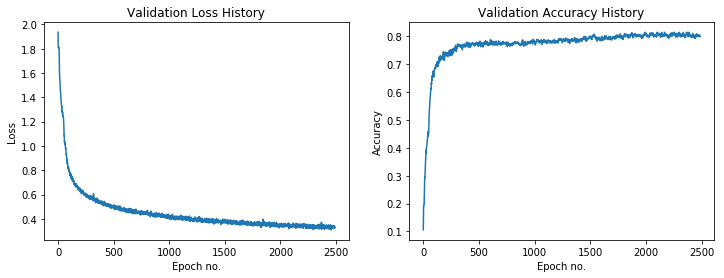

In [17]:
f, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].plot(loss_history, label='loss')
ax[0].set_title('Validation Loss History')
ax[0].set_xlabel('Epoch no.')
ax[0].set_ylabel('Loss')

ax[1].plot(smooth(acc_history, 5)[:-2], label='acc')
ax[1].set_title('Validation Accuracy History')
ax[1].set_xlabel('Epoch no.')
ax[1].set_ylabel('Accuracy');

In [18]:
test_results = []
model.load_state_dict(torch.load('best.pth'))
model.eval()
for x_raw, x_fft, _ in tst_dl:
    batches = [t.to(device) for t in (x_raw, x_fft)]
    out = model(*batches)
    y_hat = F.log_softmax(out, dim=1).argmax(dim=1)
    test_results.extend(y_hat.tolist())

In [19]:
submit = pd.read_csv(sample)
submit['surface'] = enc.inverse_transform(test_results)
submit.to_csv('submit_base.csv', index=None)

## Is It Possible to Improve?

The model shown above shows pretty good quality of predictions, especially when compared to the naïve solutions. But can we do better? Let's see if we can improve the quality of predictions using a couple of additional tricks.

First of all, we can try to use dynamic learning rate scheduling. Let's use the [One-Cycle Policy schedule](https://docs.fast.ai/training.html) inspired by L. Smith's papers.

In [20]:
def cosine(epoch, t_max, ampl):
    """Shifted and scaled cosine function."""
    
    t = epoch % t_max
    return (1 + np.cos(np.pi*t/t_max))*ampl/2

In [21]:
def inv_cosine(epoch, t_max, ampl):
    """A cosine function reflected on X-axis."""
    
    return 1 - cosine(epoch, t_max, ampl)

In [22]:
def one_cycle(epoch, t_max, a1=0.6, a2=1.0, pivot=0.3):
    """A combined schedule with two cosine half-waves."""
    
    pct = epoch / t_max
    if pct < pivot:
        return inv_cosine(epoch, pivot*t_max, a1)
    return cosine(epoch - pivot*t_max, (1-pivot)*t_max, a2)

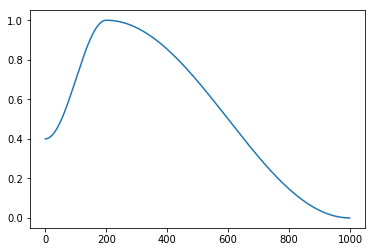

In [23]:
n = 1000
sched = partial(one_cycle, t_max=n, pivot=0.2)
items = [sched(t) for t in range(n)]
plt.plot(items);

As the picture above shows, the learning rate slowly increases up to some point, and then starts to decrese down to zero. Also note that our scheduling function returns values in range `[0, 1]`. Then we'll multiply the base learning rate set in the optimizer by these values returned from the scheduling function. Therefore, our function instead of returning absolute learning rates works as a _scaler_ that modifies the base value as training iterations increase.

In [24]:
class Scheduler:
    """Updates optimizer's learning rates using provided scheduling function."""
    
    def __init__(self, opt, schedule):
        self.opt = opt
        self.schedule = schedule
        self.history = defaultdict(list)
    
    def step(self, t):
        for i, group in enumerate(self.opt.param_groups):
            lr = opt.defaults['lr'] * self.schedule(t)
            group['lr'] = lr
            self.history[i].append(lr)

In addition, we can try to add `nn.BatchNorm1d` layers to our convolutions and use a different activation function that is [less prone to the problem of "dead neurons" which could be very prominent in case of `ReLU`](http://cs231n.github.io/neural-networks-1/#actfun). (See the section on activation functions).

In [25]:
class SepConv1d(nn.Module):
    """Implementes a 1-d convolution with 'batteries included'.
    
    The module adds (optionally) activation function and dropout 
    layers right after a separable convolution layer.
    """
    def __init__(self, ni, no, kernel, stride, pad, 
                 drop=None, bn=True,
                 activ=lambda: nn.PReLU()):
    
        super().__init__()
        assert drop is None or (0.0 < drop < 1.0)
        layers = [_SepConv1d(ni, no, kernel, stride, pad)]
        if activ:
            layers.append(activ())
        if bn:
            layers.append(nn.BatchNorm1d(no))
        if drop is not None:
            layers.append(nn.Dropout(drop))
        self.layers = nn.Sequential(*layers)
        
    def forward(self, x): 
        return self.layers(x)

Finally, we could try to increase the depth of network as soon as we included batch normalization layers and `PReLU` activations which could reduce the negative effects of increased depth.

In [26]:
class Classifier(nn.Module):
    def __init__(self, raw_ni, fft_ni, no, drop=.5):
        super().__init__()
        
        self.raw = nn.Sequential(
            SepConv1d(raw_ni,  32, 8, 2, 3, drop=drop),
            SepConv1d(    32,  32, 3, 1, 1, drop=drop),
            SepConv1d(    32,  64, 8, 4, 2, drop=drop),
            SepConv1d(    64,  64, 3, 1, 1, drop=drop),
            SepConv1d(    64, 128, 8, 4, 2, drop=drop),
            SepConv1d(   128, 128, 3, 1, 1, drop=drop),
            SepConv1d(   128, 256, 8, 4, 2),
            Flatten(),
            nn.Dropout(drop), nn.Linear(256, 64), nn.PReLU(), nn.BatchNorm1d(64),
            nn.Dropout(drop), nn.Linear( 64, 64), nn.PReLU(), nn.BatchNorm1d(64))
        
        self.fft = nn.Sequential(
            SepConv1d(fft_ni,  32, 8, 2, 4, drop=drop),
            SepConv1d(    32,  32, 3, 1, 1, drop=drop),
            SepConv1d(    32,  64, 8, 2, 4, drop=drop),
            SepConv1d(    64,  64, 3, 1, 1, drop=drop),
            SepConv1d(    64, 128, 8, 4, 4, drop=drop),
            SepConv1d(   128, 128, 8, 4, 4, drop=drop),
            SepConv1d(   128, 256, 8, 2, 3),
            Flatten(),
            nn.Dropout(drop), nn.Linear(256, 64), nn.PReLU(), nn.BatchNorm1d(64),
            nn.Dropout(drop), nn.Linear( 64, 64), nn.PReLU(), nn.BatchNorm1d(64))
        
        self.out = nn.Sequential(
            nn.Linear(128, 64), nn.ReLU(inplace=True), nn.Linear(64, no))
        
        self.init_weights(nn.init.kaiming_normal_)
        
    def init_weights(self, init_fn):
        def init(m): 
            for child in m.children():
                if isinstance(child, nn.Conv1d):
                    init_fn(child.weights)
        init(self)
        
    def forward(self, t_raw, t_fft):
        raw_out = self.raw(t_raw)
        fft_out = self.fft(t_fft)
        t_in = torch.cat([raw_out, fft_out], dim=1)
        out = self.out(t_in)
        return out

The training loop is almost exactly copied-and-pasted from the previous cell. The only change is one-cycle scheduler and learning rate updates.

In [27]:
raw_feat = raw_arr.shape[1]
fft_feat = fft_arr.shape[1]

trn_dl, val_dl, tst_dl = create_loaders(datasets, bs=256)

lr = 0.001
n_epochs = 3000
iterations_per_epoch = len(trn_dl)
period = n_epochs*iterations_per_epoch
num_classes = 9
best_acc = 0
patience, trials = 500, 0
base = 1
step = 2
iteration = 0
loss_history = []
acc_history = []

model = Classifier(raw_feat, fft_feat, num_classes).to(device)
criterion = nn.CrossEntropyLoss(reduction='sum')
opt = optim.Adam(model.parameters(), lr=lr)

# one-cycle learning rate scheduling
sched = Scheduler(opt, partial(one_cycle, t_max=period, pivot=0.3))

print('Start model training')

for epoch in range(1, n_epochs + 1):
    
    model.train()
    epoch_loss = 0
    for i, batch in enumerate(trn_dl):
        iteration += 1
        x_raw, x_fft, y_batch = [t.to(device) for t in batch]
        sched.step(iteration)  # update the learning rate
        opt.zero_grad()
        out = model(x_raw, x_fft)
        loss = criterion(out, y_batch)
        epoch_loss += loss.item()
        loss.backward()
        opt.step()
        
    epoch_loss /= trn_sz
    loss_history.append(epoch_loss)
    
    model.eval()
    correct, total = 0, 0
    for batch in val_dl:
        x_raw, x_fft, y_batch = [t.to(device) for t in batch]
        out = model(x_raw, x_fft)
        preds = F.log_softmax(out, dim=1).argmax(dim=1)
        total += y_batch.size(0)
        correct += (preds == y_batch).sum().item()
    
    acc = correct / total
    acc_history.append(acc)

    if epoch % base == 0:
        print(f'Epoch: {epoch:3d}. Loss: {epoch_loss:.4f}. Acc.: {acc:2.2%}')
        base *= step

    if acc > best_acc:
        trials = 0
        best_acc = acc
        torch.save(model.state_dict(), 'best.pth')
        print(f'Epoch {epoch} best model saved with accuracy: {best_acc:2.2%}')
    else:
        trials += 1
        if trials >= patience:
            print(f'Early stopping on epoch {epoch}')
            break
            
print('Done!')

Start model training
Epoch:   1. Loss: 1.9626. Acc.: 12.60%
Epoch 1 best model saved with accuracy: 12.60%
Epoch:   2. Loss: 1.9263. Acc.: 16.54%
Epoch 2 best model saved with accuracy: 16.54%
Epoch:   4. Loss: 1.8455. Acc.: 16.54%
Epoch 7 best model saved with accuracy: 16.80%
Epoch:   8. Loss: 1.6747. Acc.: 16.80%
Epoch 9 best model saved with accuracy: 17.06%
Epoch 12 best model saved with accuracy: 17.59%
Epoch 13 best model saved with accuracy: 18.11%
Epoch 15 best model saved with accuracy: 18.37%
Epoch:  16. Loss: 1.5411. Acc.: 18.64%
Epoch 16 best model saved with accuracy: 18.64%
Epoch 17 best model saved with accuracy: 19.16%
Epoch 18 best model saved with accuracy: 19.69%
Epoch 19 best model saved with accuracy: 20.47%
Epoch 20 best model saved with accuracy: 21.00%
Epoch 21 best model saved with accuracy: 23.36%
Epoch 23 best model saved with accuracy: 24.41%
Epoch 26 best model saved with accuracy: 26.51%
Epoch 30 best model saved with accuracy: 28.87%
Epoch:  32. Loss: 1.

Finally, let's plot the training history and run the new model on the testing dataset.

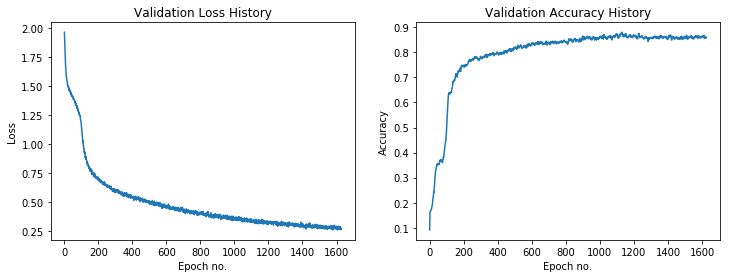

In [28]:
f, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].plot(loss_history, label='loss')
ax[0].set_title('Validation Loss History')
ax[0].set_xlabel('Epoch no.')
ax[0].set_ylabel('Loss')

ax[1].plot(smooth(acc_history, 5)[:-2], label='acc')
ax[1].set_title('Validation Accuracy History')
ax[1].set_xlabel('Epoch no.')
ax[1].set_ylabel('Accuracy');

In [29]:
test_results = []
model.load_state_dict(torch.load('best.pth'))
model.eval()
for x_raw, x_fft, _ in tst_dl:
    batches = [t.to(device) for t in (x_raw, x_fft)]
    out = model(*batches)
    y_hat = F.log_softmax(out, dim=1).argmax(dim=1)
    test_results.extend(y_hat.tolist())

In [30]:
submit = pd.read_csv(sample)
submit['surface'] = enc.inverse_transform(test_results)
submit.to_csv('submit_one_cycle.csv', index=None)

The new model usually performs a bit better on validation subset than the original one but the result is not too stable. It has changed a couple of times from one kernel run to another. If you try to submit two files to the leaderboard, you usually should see a better score for the later model as a screenshot below shows. So probably it is a good idea to train several models and average their predictions. (As the author of the original kernel did).

![](https://i.imgur.com/94AuMAO.png)

## Conclusion

The Deep Learning models are very powerful solutions to a wide range of Data Science projects. However, even these powerful solutions can't show good results if used naively and without additional efforts to make a proper preparation of the data. The more work we spend to help our models, the better results they will show.